<a href="https://colab.research.google.com/github/paulxshen/Luminescent.jl/blob/master/Luminescent_AI_docs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Luminescent AI - FDTD Simulation and Inverse Design

2025/03/23  
Paul Shen <pxshen@alumni.stanford.edu>  



# Summary

[Luminescent AI](https://luminescentai.com/) enables generative design and simulation of electromagnetic structures  in just a few lines of code! We help design next generation photonic integrated circuits, RF microstrip circuits, antennas and metasurfaces in diverse industries including consumer electronics, automotive, telecom, datacenters and quantum computing.

We created an automatic differentiation (AD) and GPU compatible finite difference time domain (FDTD) simulator and geometry generator. CPU only installer (binaries) on Linux and Windows are freely available and used in this notebook! GPU installer and advanced functionalities are premium features.


# Features
**Fast**
- ✨GPU acceleration
- Adaptive meshing slashes cell count  

**Smart**
- Generative AI design of 2D and 3D structures
- Fully differentiable for inverse design
- Automatic differentiation (AD) gradients for adjoint optimization
- Length scale controlled geometry optimizer with fabrication constraints  

**Easy**
- Generative design and simulation in just few lines of Python code!
- Automated S-parameters calculation supporting broadband and multimode
- Application specific API
    - Photonic integrated circuits with gdsfactory integration
    - ✨Optical metasurfaces
    - ✨RF microstrip, CPWG circuits and patch antennas
- ✨General 3D geometry import via .stl, .step  

**Comprehensive**
- Tensor subpixel smoothing for accuracy
- Embedded mode solver for modal sources and monitors
- Modal sources, plane waves, Gaussian beams, arbitrary current excitations
- Oblique sources and monitors
- PML, periodic, PEC, PMC boundaries
- ✨Nonlinear, dispersive and anisotropic materials

✨Premium features

[Follow us](https://www.linkedin.com/company/luminescent-ai/about) for updates! Star us [GitHub](https://github.com/paulxshen/Luminescent.jl) if you like our work. We respond daily to issues. Experimental release 🥼. Expect critters  🐛🐞

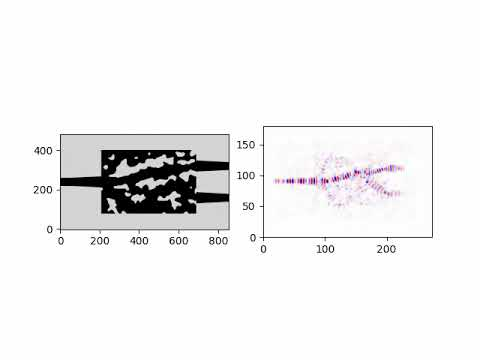

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo('5699mEDGz7c')

AI generated mode converter and wavelength domain demultiplexer

# Installation

Free CPU installer on Linux. Tutorials in this notebook ran on free Google Colab TPU runtime which has better CPU and RAM - we don't actually use the TPU.  Contact us for premium GPU installer which is 20x faster than CPU.

In [7]:
%%shell
# Works on Python 3.11 but not 3.12 due to a descrepancy in gdsfactory frontend.
pip install -U luminescent &> /dev/null
gdown 1V-rDPoHkt4GAeJBdzAGn24ztaPkw3kxF
tar -xf lumi.tar.gz  -C /usr/local/

In [1]:
import os
os.environ['PATH'] += ':/usr/local/Luminescent/bin'

# Application: photonic integrated circuits

## Workflow

### Geometry layout
We layout using Python gdsfactory. Can also import .gds into gdsfactory . Internally, gdsfactory component and layer stack let generate a 3D mesh that we rasterize. By default, we apply a SOI 220nm node but we can create any layer stack in gdsfactory


### Materials
We map gdsfactory layerstack layers to materials via the layer's material property. Dispersive, anisotropic, and nonlinear materials are by default not simulated but can be implemented upon request.

### Margins and ports
Port numbers map to gdsfactory component ports. Specify port pairs as eg `2,1` which is equivalent to `o2@0,o1@0` meaning optical_port_number@mode_number.

### Reciprocity and symmetry
Usually only a subset of sparams is needed because of symmetry or reciprocity, specified as `keys` in sparams study or inferred automatically from inverse design study. We do a run for each port excitation. If `keys` is omitted in sparams study, all sparams will be calculated requiring more runs.

### File workflow
Each simulation or design optimization run is saved to a folder path. Can access saved runs via `load`, `finetune`

## Simulation tutorials

### waveguide bend

New topics
- Geometry layout
- Sparams setup

We simulate a circular bend of R=5um the often cited minimum radius in silicon photonics. We use `gdsfactory` to make the bend.

`nres` is the number of points per wavelength in material (not in vacuum) of the adaptive grid. Thus higher refractive index regions have a finer local grid. Remember FDTD scales as O(n^4)! `nres` has a huge effect on simulation time! Finally, Because of reciprocity we only need S or T param keys of "2,1".

Source port margin of couple wavelengths improve accuracy at coarse resolutions because of source mode profile mismatch

running luminescent python frontend


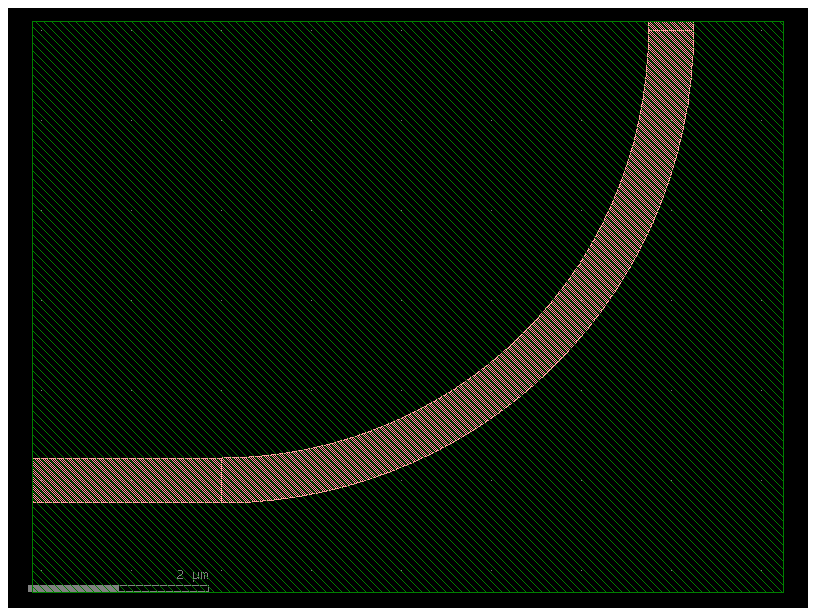

In [4]:
import luminescent as lumi
import gdsfactory as gf
import numpy as np
import os

radius = 5
source_port_margin = 2

c=gf.Component()

dut=c<< gf.components.bend_circular(radius)
ext1=c<<gf.components.straight(length=source_port_margin+.1)
ext2=c<<gf.components.straight(length=.1)

ext1.connect("o2",dut.ports["o1"])
ext2.connect("o1",dut.ports["o2"])

c.add_port("o1", port=dut.ports["o1"])
c.add_port("o2", port=dut.ports["o2"])

c << gf.components.bbox(component=c, layer=lumi.BBOX, right=1, bottom=1)
c.plot()


In [8]:
keys = ["2,1"]  # same as keys=["o2@0,o1@0"]
nres = 8
wavelengths = 1.55
materials = lumi.MATERIALS
layer_stack = lumi.SOI
gpu = None
path = os.path.join("runs", f"bend_R{radius}")

lumi.make_prob(
    path, c, wavelengths=wavelengths,  keys=keys, gpu=gpu,
nres=nres,source_port_margin=source_port_margin,
    materials=materials, layer_stack=layer_stack)
lumi.solve(path)
sol=lumi.load(path)


loading solution from /content/runs/bend_R5
{'S': {'1.55': {'o1@0,o1@0': (0.053525172+0.0058927867j),
                'o2@0,o1@0': (-0.978604+0.18420321j)}},
 'T': {'1.55': {'o1@0,o1@0': 0.0028996689, 'o2@0,o1@0': 0.99159664}},
 'dB': {'1.55': {'o1@0,o1@0': -25.376514, 'o2@0,o1@0': -0.03664954}},
 'phasors': {'1.55': {'o1@0,o1@0': {'mag': 0.053848576, 'phase': 6.2826047},
                      'o2@0,o1@0': {'mag': 0.99578947, 'phase': 169.3399}}}}
2025-03-23 16:32:48.170 | ERROR    | gdsfactory.read.import_gds:kcell_to_component:58 - Name conflict in gdsfactory.read.import_gds::kcell_to_component at line 58
Renaming Unnamed_7 to Unnamed_0 would cause it to be named the same as:
 - Unnamed_0 (cell_index=0), function_name=None, basename=None
 - Unnamed_0 (cell_index=5), function_name=None, basename=None
 - Unnamed_0 (cell_index=6), function_name=None, basename=None


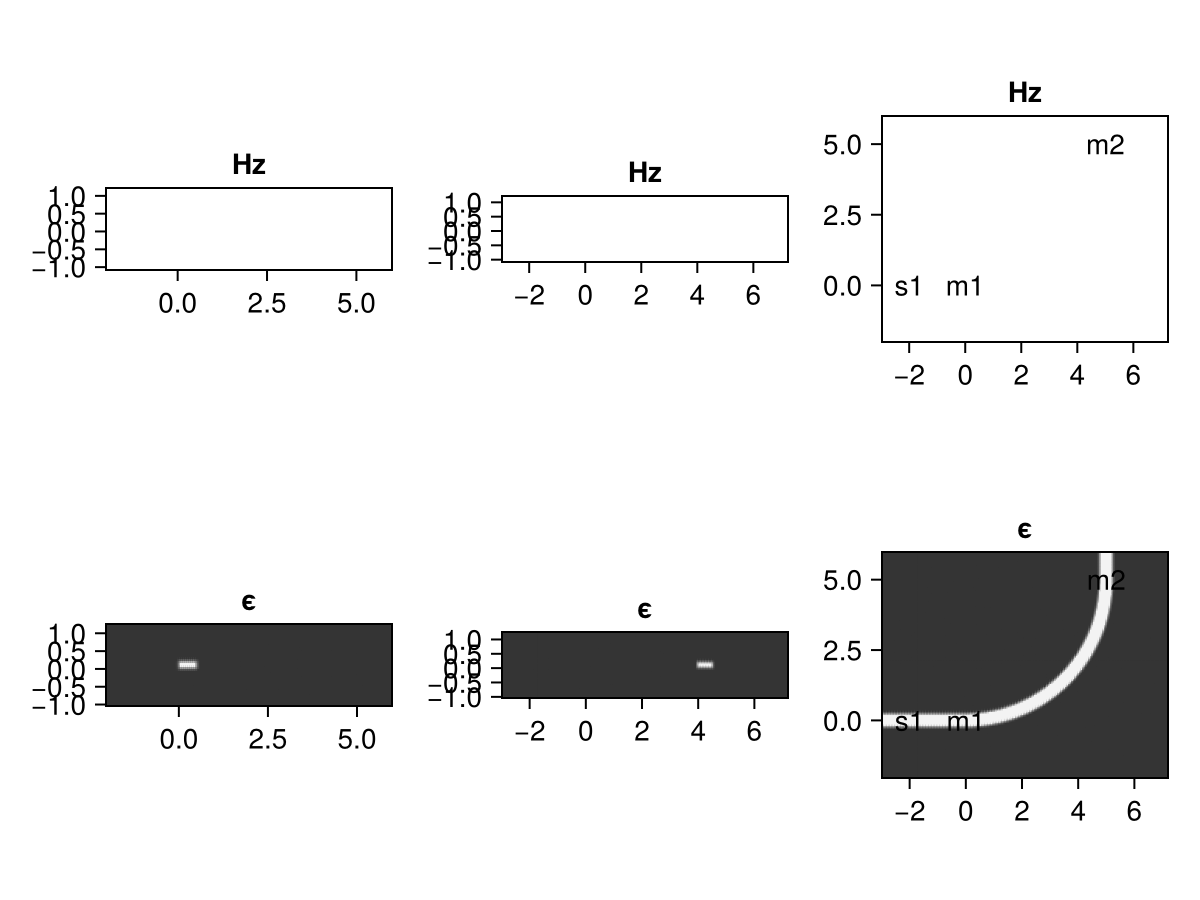

In [9]:
from IPython.display import Image
GIF = os.path.join(path, "sim.gif")
Image(open(GIF,'rb').read())

### Ring resonator

New topics:
- Broadband (multiple wavelengths)
- Custom layer stack
- Custom material properties

Similr to Lumerical resonator example. Lossy, FSR of few nm around 1.55um. Resonators require much longer integration periods (eg T='8x') because signal goes round and round before decaying.


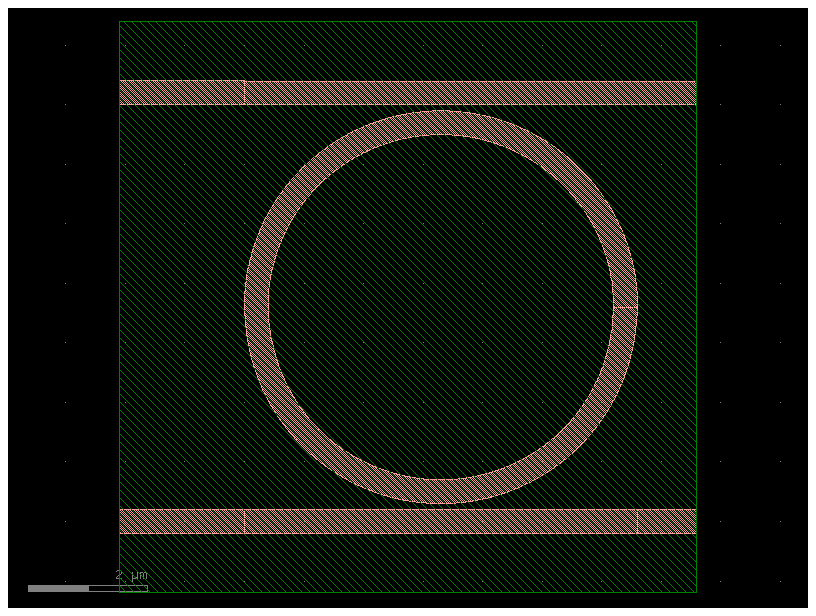

In [13]:
import luminescent as lumi
from gdsfactory.technology import LogicalLayer, LayerLevel, LayerStack
import gdsfactory as gf
import numpy as np
import os

radius = 3.1
width = 0.4
gap = .1
source_port_margin = 2

c = gf.Component()
wg1 = c<<gf.components.straight(length=2*radius+width, width=width)
wg2 = c<<gf.components.straight(length=2*radius+width+1, width=width)
dut = c<<gf.components.ring(radius=radius, width=width)
ext1 = c<<gf.components.straight(length=source_port_margin+.1, width=width)
ext3 = c<<gf.components.straight(length=source_port_margin+.1, width=width)
ext2 = c<<gf.components.straight(length=1, width=width)

dut.move((radius+width/2, width+gap+radius))
wg2.movey(2*(width+gap+radius))
ext1.connect("o2", wg1.ports["o1"])
ext2.connect("o1", wg1.ports["o2"])
ext3.connect("o2", wg2.ports["o1"])

c.add_port("o1", port=wg1.ports["o1"])
c.add_port("o2", port=wg1.ports["o2"])
c.add_port("o3", port=wg2.ports["o1"])

c << gf.components.bbox(component=c, layer=lumi.BBOX, top=1, bottom=1)
c.plot()

# custom layer stack
layers = {
    "core": LayerLevel(
        layer=LogicalLayer(layer=(1, 0)),
        thickness=0.18,
        zmin=0.0,
        material="Si",
        mesh_order=2,
    ),
}

SOI180 = LayerStack(layers=layers)
SOI180.layers['default'] = {
    'material': 'SiO2'
}

# custom materials

In [15]:
keys = ["2,1","3,1"]
nres = 6
gpu = None
materials = lumi.MATERIALS
layer_stack = SOI180
wavelengths = np.linspace(1.53, 1.57, 17).tolist()
path = os.path.join("runs", "ring")

lumi.make_prob(
    path, c, wavelengths=wavelengths,
    nres=nres, keys=keys,T='8x', gpu=gpu,
    source_port_margin=source_port_margin,
    materials=materials, layer_stack=layer_stack)
lumi.solve(path)
sol=lumi.load(path)

using simulation folder runs/ring

running Luminescent julia backend
λ = F(center_wavelength) = 1.55f0
setting up simulation...
meshing geometry - can take few minutes...
424.269212 seconds (195.86 M allocations: 702.412 GiB, 8.70% gc time, 0.27% compilation time)
making sources...
solving modal profile...
making monitors...
using saved mode solutions
using saved mode solutions
using saved mode solutions
----------------------------------------

simulation setup complete

backend: CPU
float: Float32

original size: (131, 121, 19)
padded size: (187, 145, 23)
cell count: 623,645

total time: 142.71 periods
time steps: 4,424

computation load: 2,759,005,480 cell-steps

compiling simulation code...
accumulating dft fields...
period 0.0,  0.00 seconds/period
period 2.0,  9.30 seconds/period
period 4.0,  9.26 seconds/period
period 6.0,  9.42 seconds/period
period 8.0,  9.00 seconds/period
period 10.0,  9.70 seconds/period
period 12.0,  9.88 seconds/period
period 14.0,  9.93 seconds/period
pe

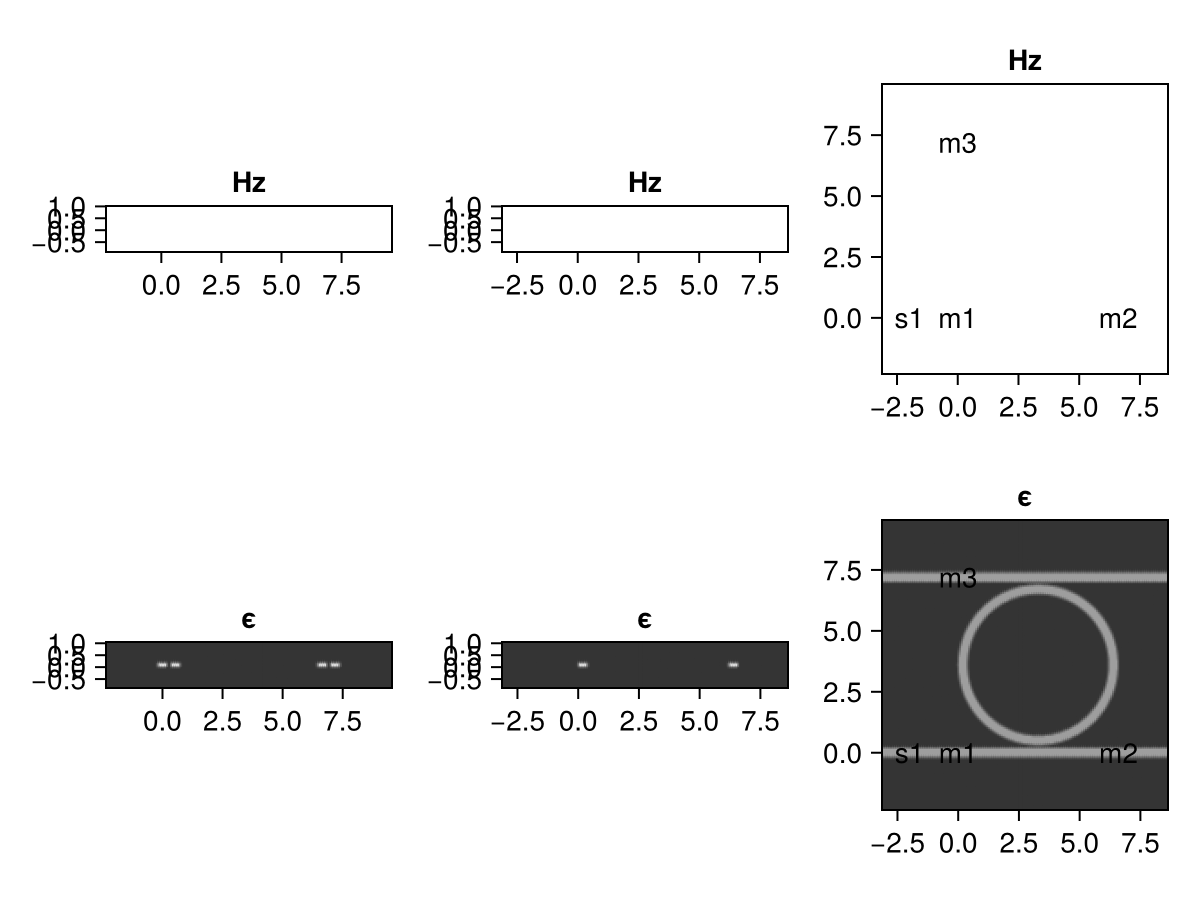

In [16]:
from IPython.display import Image
GIF = os.path.join(path, "sim.gif")
Image(open(GIF,'rb').read())

## Generative inverse design tutorials
We introduce GCells (generative cells), a natural evolution of PCells (parametric cells) in semiconductor design . Given a set of inverse design objectives, a GCell will generate optimal geometry using adjoint optimization while ensuring manufacturability by enforcing minimum feature lengths.

In examples below, `mimo` (multi in multi out) is just a gdsfactory component with configurable waveguide ports, simple slab as pre-optimization geometry, and overlying rectangular design regions. Dimensions `l` along x and `w` along y. Ports are numbered incrementally: west (SW->NW) -> east (SE->NE) -> south (SW->SE) -> north (NW->NE). By default, they're spaced equally on a side. Example: `west=1, east=2` places port 1 on west, ports 2 & 3 on east. But can also individually specify their locations and widths. Example : `west=[1.0, 2.5], wwg_west=[0.5, 0.4]`.

Optimization `targets` is a dictionary organized wrt target type & wavelength. Types include T-params (`tparams`, most common), phase difference (`phasediff`), S-params (`sparams`). Multiple types & wavelengths are possible & often necessary . Loss for each type is scaled automatically to vary from 0 to 1 usually . For example , `tparams` loss of 0.5 roughly means 50% of power going to wrong places.

`lvoid` is minimum length scale for voids. No void features smaller than it (currently this isn't exact - contact us for a more precise algorithm). Similarly for `lsolid`.

Setting `approx_2D_mode="TE"` (or "TM") optimizes in 2.5D which serves as a fast initialization for 3D optimization. Examples done at low resolution and lax convergence in 2.5D on CPU. For accuracy, the result must be finetuned in 3D at finer resolution, a feature that can be requested from Luminescent AI .


### wavelength domain demultiplexer

We inverse design a 1x2 wavelength demultiplexer separating different wavelength signals. All we need to do is specify the wavelength dependent Tparams targets.

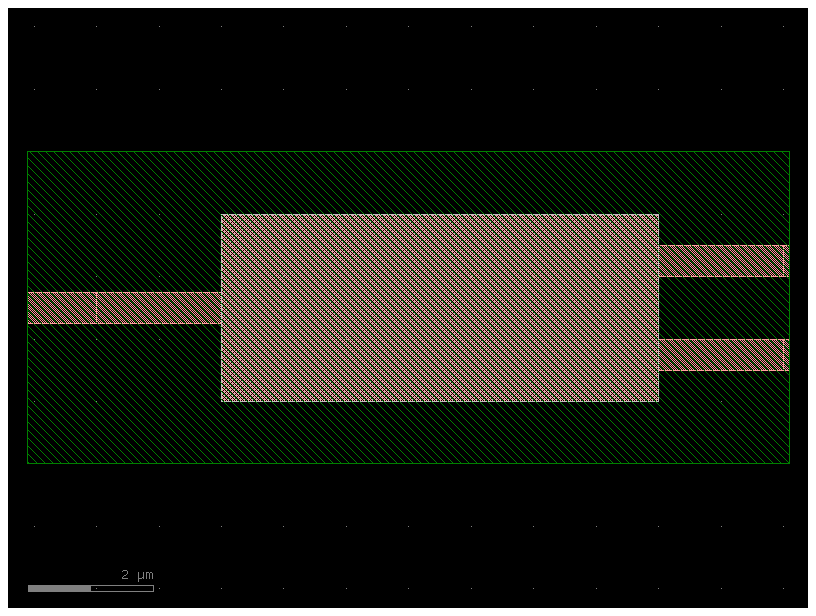

In [ ]:
# 16G RAM, 0.5h on colab free tpu runtime (tpu not used)
import os
import luminescent as lumi
import gdsfactory as gf

source_port_margin=1

c=gf.Component()
dut =c<< lumi.mimo(west=1, east=2, l=7.0, w=3.0, wwg=.5)
ext1=c<<gf.components.straight(source_port_margin+.1)
ext2=c<<gf.components.straight(.1)
ext3=c<<gf.components.straight(.1)

ext1.connect("o2", dut.ports["o1"])
ext2.connect("o1", dut.ports["o2"])
ext3.connect("o1", dut.ports["o3"])

c.add_port("o1", port=dut.ports["o1"])
c.add_port("o2", port=dut.ports["o2"])
c.add_port("o3", port=dut.ports["o3"])

c << gf.components.bbox(component=c, layer=lumi.BBOX, top=1, bottom=1)
c.plot()


In [ ]:
targets = {"tparams": {
    1.2: {"3,1": 1.0},
    1.8: {"2,1": 1.0},
}}
path = os.path.join("runs", "demux")

lumi.make_design_prob(
    path, c, targets,
    nres=8,approx_2D_mode="TE",lvoid=0.1, source_port_margin=source_port_margin,
            fill_material="Si", void_material="SiO2",
    dtype="float16", stoploss=.05, iters=50, )
lumi.solve(path)

Lets see simulation fields and optimized geometry.

loading solution from /content/runs/demux


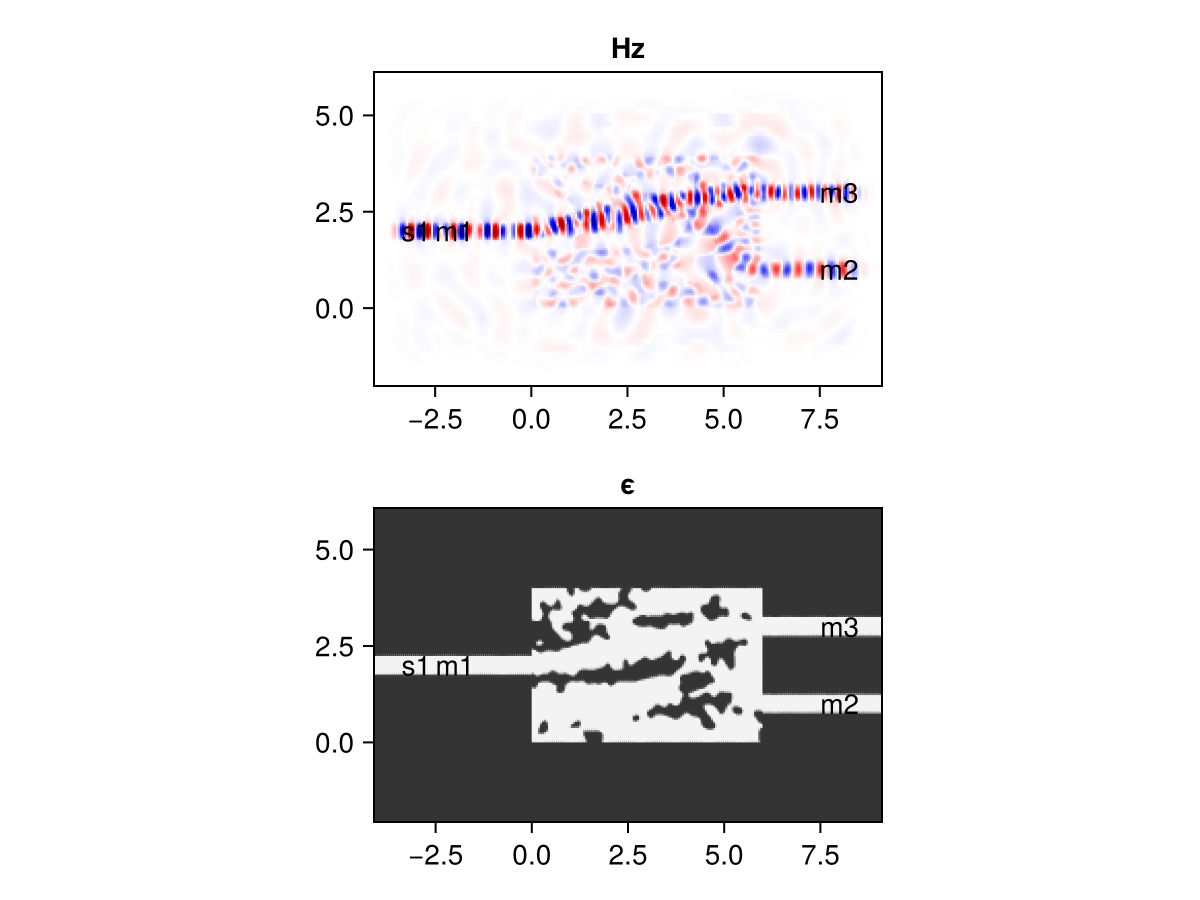

{'S': {'1.2': {'o1@0,o1@0': (0.05414-0.03375j),
               'o2@0,o1@0': (0.001339+0.0152j),
               'o3@0,o1@0': (-0.9287+0.2156j)},
       '1.7999999999999998': {'o1@0,o1@0': (-0.1136-0.00737j),
                              'o2@0,o1@0': (0.2876-0.8413j),
                              'o3@0,o1@0': (-0.2114-0.08813j)}},
 'T': {'1.2': {'o1@0,o1@0': 0.00407,
               'o2@0,o1@0': 0.0002328,
               'o3@0,o1@0': 0.9087},
       '1.7999999999999998': {'o1@0,o1@0': 0.012955,
                              'o2@0,o1@0': 0.7905,
                              'o3@0,o1@0': 0.0525}},
 'dB': {'1.2': {'o1@0,o1@0': -23.9, 'o2@0,o1@0': -36.3, 'o3@0,o1@0': -0.416},
        '1.7999999999999998': {'o1@0,o1@0': -18.88,
                               'o2@0,o1@0': -1.021,
                               'o3@0,o1@0': -12.805}},
 'phasors': {'1.2': {'o1@0,o1@0': {'mag': 0.0638, 'phase': -31.95},
                     'o2@0,o1@0': {'mag': 0.01526, 'phase': 85.0},
                     'o3@

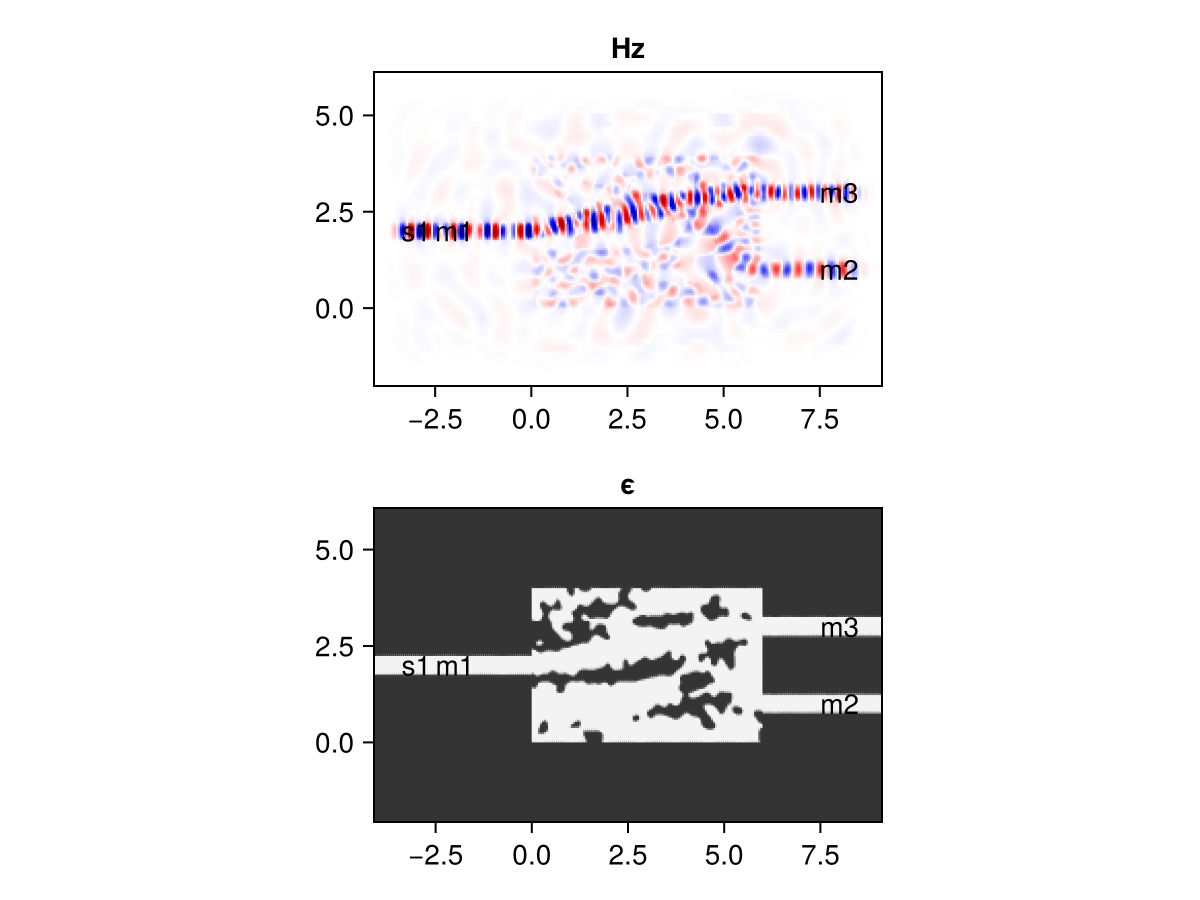

In [ ]:
sol = lumi.load(path)

Can optionally optimize with additional iterations using `finetune`

In [ ]:
# lumi.finetune(path,stoploss=.03,iters=40)

### 1x2 splitter MMI
1.55um wavelength 1x2 splitter. We set symmetry about y so only need to specify T21=.5 as optimization target. Data saved to `path` folder inside working directory. We start iteratiions of adjoint optimization.

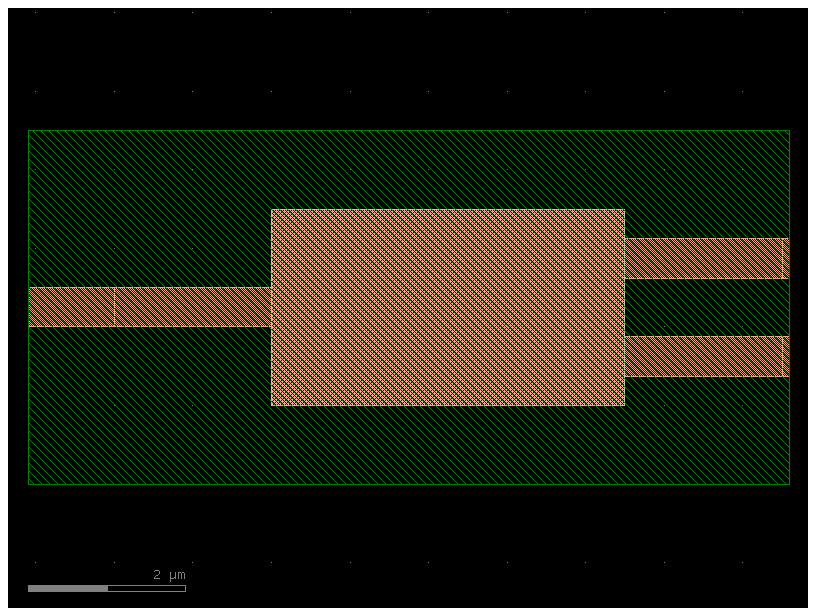

In [10]:
source_port_margin=1

c=gf.Component()
dut =c<< lumi.mimo(west=1, east=2, l=4.5, w=2.5, wwg=.5)
ext1=c<<gf.components.straight(source_port_margin+.1)
ext2=c<<gf.components.straight(.1)
ext3=c<<gf.components.straight(.1)

ext1.connect("o2", dut.ports["o1"])
ext2.connect("o1", dut.ports["o2"])
ext3.connect("o1", dut.ports["o3"])

c.add_port("o1", port=dut.ports["o1"])
c.add_port("o2", port=dut.ports["o2"])
c.add_port("o3", port=dut.ports["o3"])

c << gf.components.bbox(component=c, layer=lumi.BBOX, top=1, bottom=1)
c.plot()

In [ ]:
path = os.path.join("runs","splitter")
targets = {
    "tparams": {1.55: {"2,1": 0.5,"3,1": 0.5}},
}

lumi.make_design_prob(
    path,c, targets,
    lvoid=0.15, nres=6,  symmetries=[1],
        fill_material="Si", void_material="SiO2",
    source_port_margin=source_port_margin,
    iters=50, stoploss=.05,
    approx_2D_mode="TE",dtype="float16")
lumi.solve(path)

# Links
[GitHub](https://github.com/paulxshen/Luminescent.jl): Star us :) We respond to issues within a day  
[LinkedIn](https://www.linkedin.com/company/luminescent-ai/about): Follow us for new features and bug fixes  
[Company](luminescentai.com): Consulting, collaboration, publication opportunities available  

WhatsApp: 650-776-7724  
WeChat: pxshen1230  
Email:
- pxshen@alumni.stanford.edu (personal, academic)
- info@luminescentai.com (commercial)  
<!-- [Youtube](https://www.youtube.com/playlist?list=PLaK09N11V08geHeqyLJLDAW0tiDeJtnd4): Video tutorials   -->